# Kernel guideline

### Version 2 - start here
* Image size 128x128
* Unet with pretrained resnet34 encoder
* Best threshold selection
* Output visualization
* Total run time of about 34 minutes

### Version 3 - 5-fold ensemble
* Example of 5-fold ensemble using sklearn KFold function, based on version 2
* Changed learning rates
* Total run time of about 132 minutes

### Version 4 - 256x256 
* Based on version 2 but with images of size 256x256
* Batch size reduced to 32

### Where to go next?
* Look at as many examples as you can and try to understand why the model fails when it does;
* There are several ways to convert a 1024x1024 to a lower resolution (e.g., bilinear, nearest), some may be more appropriate to this competition than others;
* Progressive rescaling (start with small images like 64x64, train, save the weights, increase to 128x128, train with previous weights, and so on);

In [1]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

import fastai
from fastai.vision import *
from mask_functions import *

In [2]:
fastai.__version__

'1.0.54'

In [3]:
SZ = 256
path = Path(f'../input/pneumotorax{SZ}/data{SZ}/data{SZ}')

In [4]:
# copy pretrained weights for resnet34 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet34/resnet34.pth' '/tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

In [5]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [6]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((path/'test').ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=32)
        .normalize(imagenet_stats))

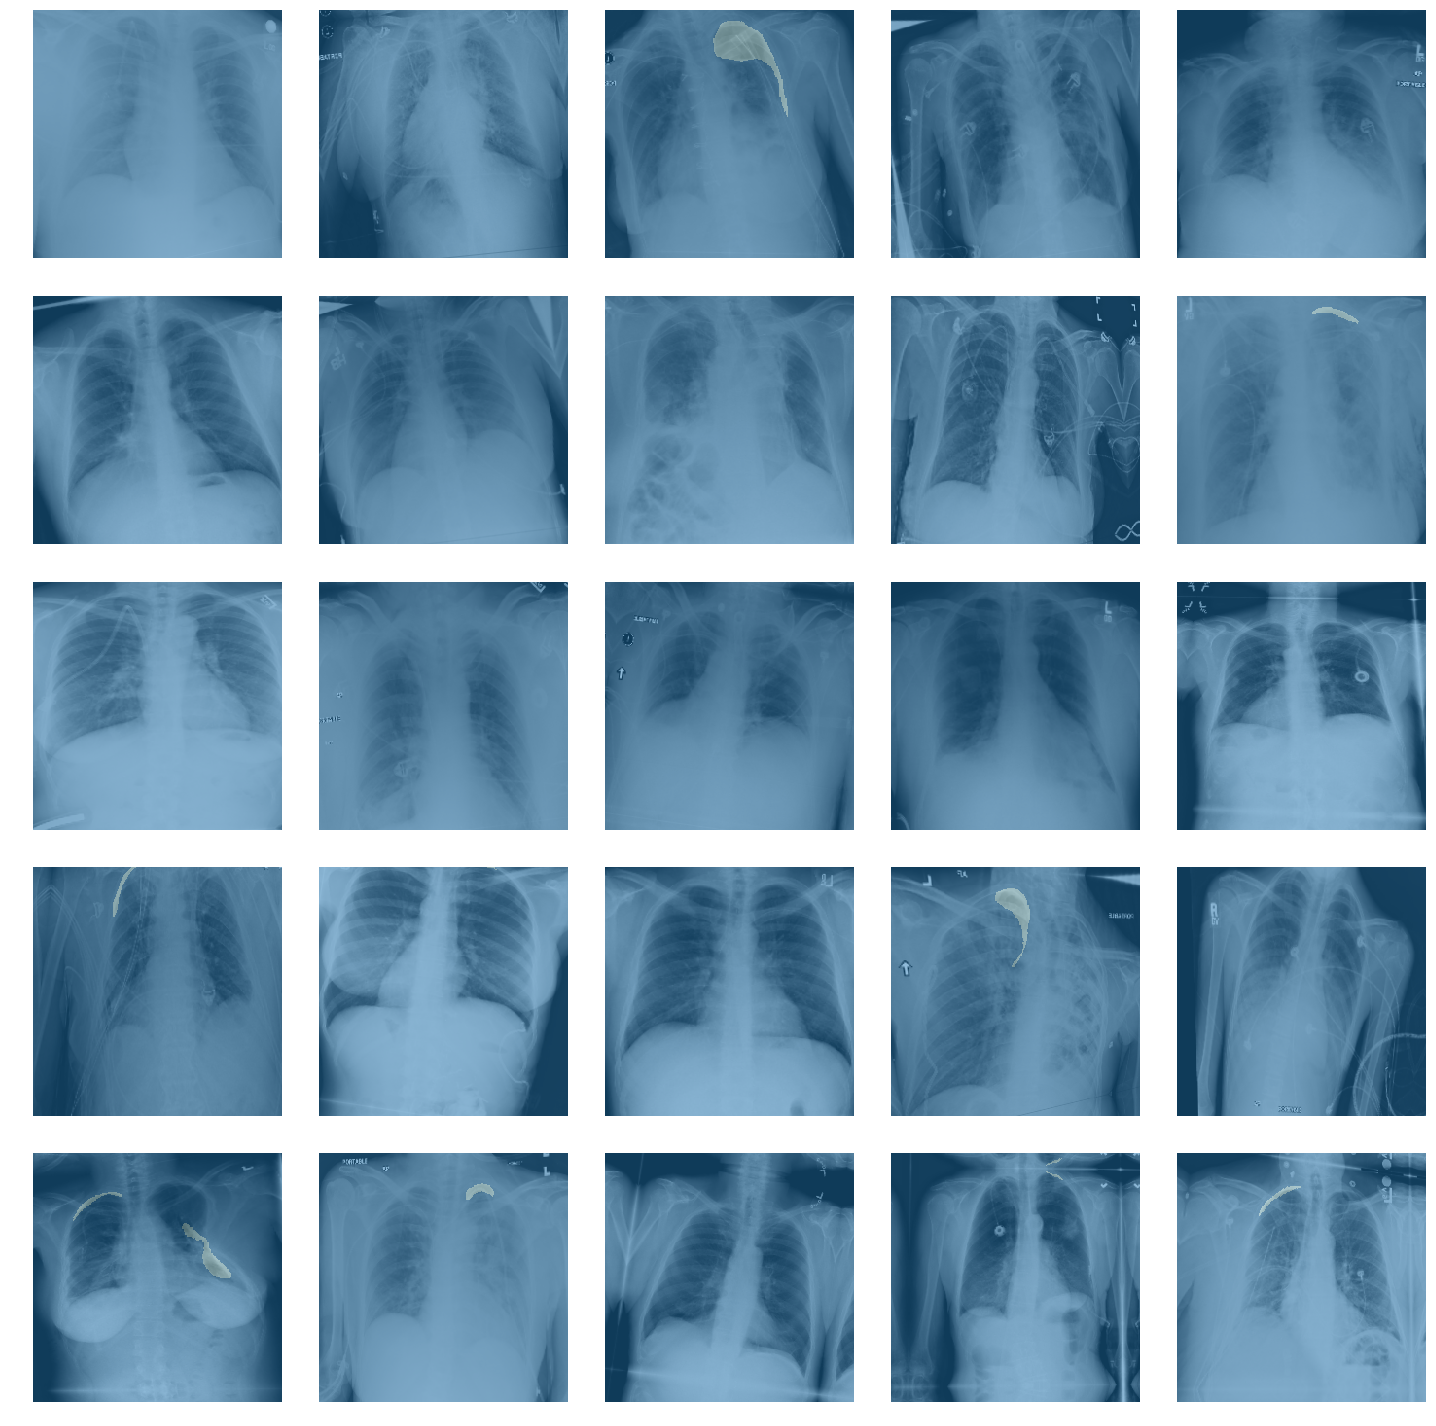

In [7]:
# Display some images with masks
data.show_batch()

In [8]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=[dice])

In [9]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,dice,time
0,0.017440,0.014704,0.000000,04:44
1,0.021763,0.021097,0.000000,04:30
2,0.014256,0.012242,0.004175,04:29
3,0.012359,0.012511,0.005286,04:29
4,0.011169,0.010838,0.102098,04:29
5,0.009496,0.010509,0.112071,04:29


In [10]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [11]:
# Fit one cycle of 12 epochs
lr = 1e-3
learn.fit_one_cycle(12, slice(lr/30, lr))

epoch,train_loss,valid_loss,dice,time
0,0.010892,0.010606,0.129038,04:38
1,0.010710,0.012233,0.087856,04:38
2,0.011174,0.012166,0.113929,04:38
3,0.011181,0.013057,0.068820,04:38
4,0.011606,0.011981,0.091870,04:38
5,0.011209,0.012117,0.026777,04:38
6,0.011126,0.012465,0.062947,04:38
7,0.010383,0.011818,0.121049,04:38
8,0.009929,0.010303,0.178029,04:38
9,0.009080,0.010364,0.189114,04:38


In [12]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [13]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [14]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

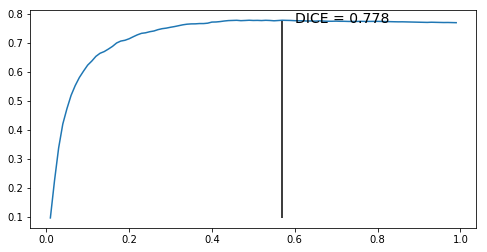

In [15]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

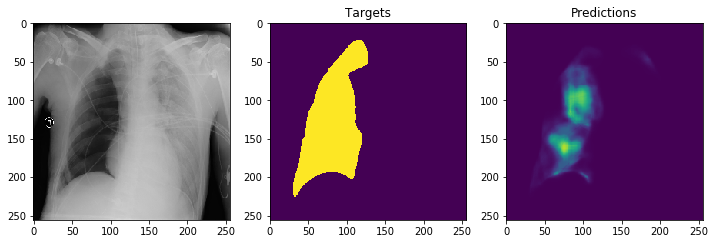

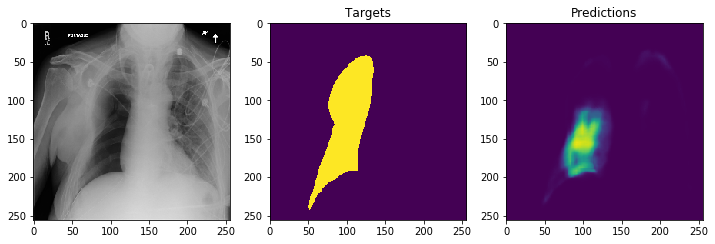

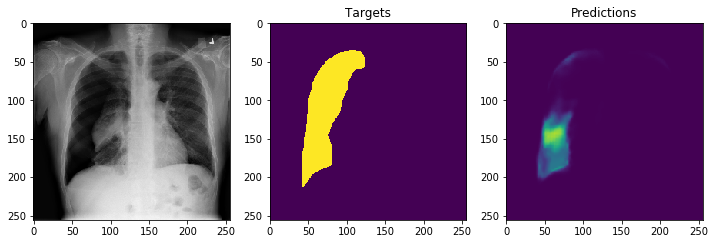

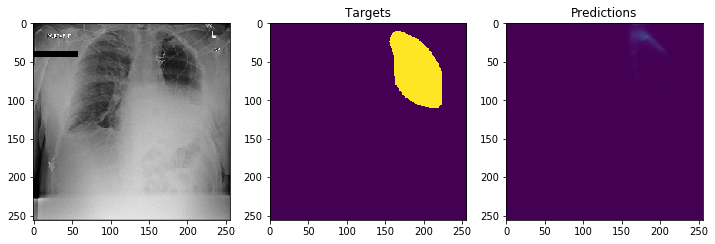

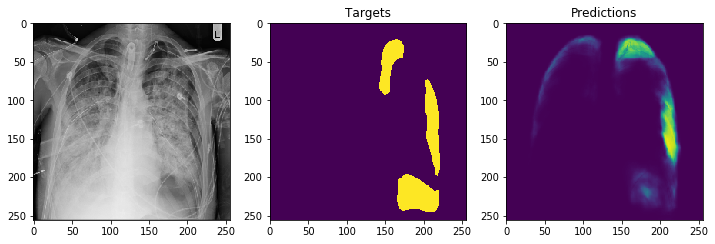

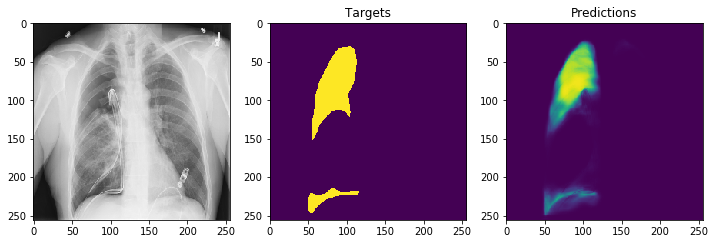

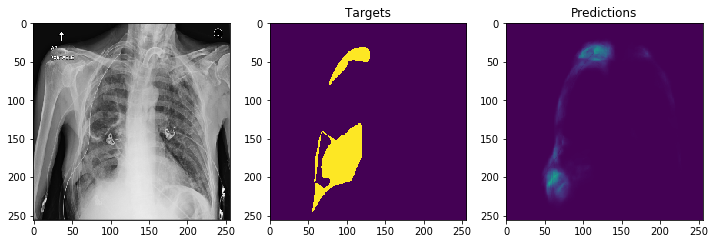

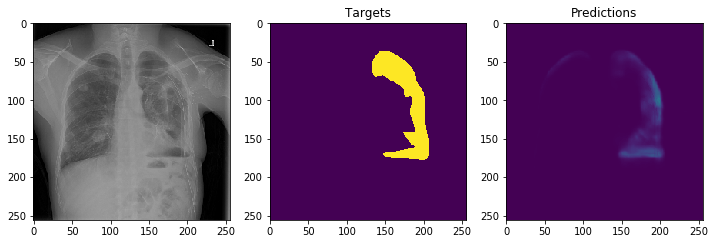

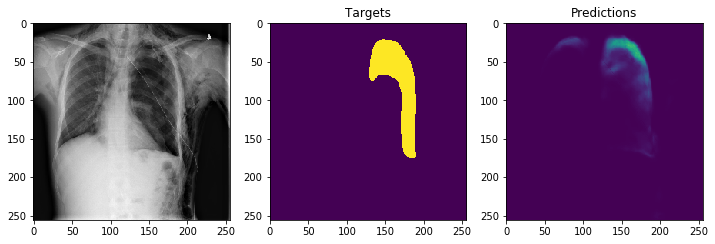

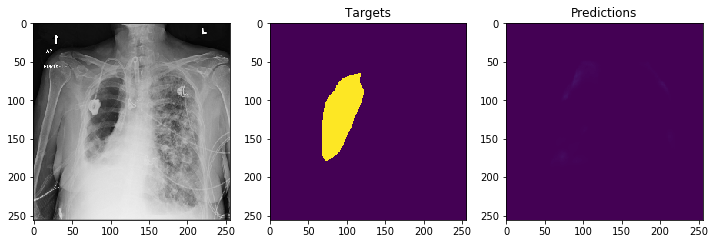

In [16]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

In [17]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

32450


In [18]:
# Generate rle encodings (images are first converted to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [19]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6915.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6570.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6335.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6760.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.594.1517875163...,-1


In [20]:
sub_df.to_csv('submission.csv', index=False)